In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
#from sklearn.pipeline import plot_pipeline
from sklearn import set_config
import holidays

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")

# Feature Engineering

In [3]:
def _extract_date_components(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    return X

def _apply_cyclical_encoding(X):
    X = X.copy()
    # Apply cyclical encoding
    X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)
    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)
    X["weekday_sin"] = np.sin(2 * np.pi * X["weekday"] / 7)
    X["weekday_cos"] = np.cos(2 * np.pi * X["weekday"] / 7)
    return X

def _encode_categorical_features(X):
    X = X.copy()
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded_features = encoder.fit_transform(X[["counter_name", "site_name"]])
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=encoder.get_feature_names_out(["counter_name", "site_name"]),
        index=X.index
    )
    # Drop original columns and add encoded features
    X = X.drop(columns=["counter_name", "site_name"], errors="ignore")
    X = pd.concat([X, encoded_df], axis=1)
    
    return X

def _add_rush_hour_indicator(X):
    X = X.copy()
    X["is_rush_hour"] = X["hour"].isin([7, 8, 9, 17, 18, 19]).astype(int)
    return X

def _add_weekend_indicator(X):
    X = X.copy()
    X["is_weekend"] = (X["weekday"] >= 5).astype(int)
    return X

def _add_holiday_indicator(X):
    X = X.copy()
    france_holidays = holidays.FR()  # Use the holidays package for France
    X["is_holiday"] = X["date"].dt.date.apply(lambda x: 1 if x in france_holidays else 0)
    return X

# Define feature dropping for low predictive value and date
def _drop_low_value_features(X):
    X = X.copy()
    X.drop(columns=['date', 'year', 'month', 'day', 'site_id', 'counter_id', 'date', 'counter_installation_date', 
                    'counter_technical_id', 'coordinates', 'latitude', 'longitude'], inplace=True)
    return X

tourist_locations = {
    "Eiffel Tower": (48.8584, 2.2945),
    "Louvre Museum": (48.8606, 2.3376),
    "Notre Dame Cathedral": (48.852968, 2.349902),
    "Sacré-Cœur": (48.8867, 2.3431),
    "Arc de Triomphe": (48.8738, 2.2950),
    "Châtelet Station": (48.8581, 2.3470),
    "Gare du Nord": (48.8808, 2.3553),
    "Montparnasse Tower": (48.8422, 2.3211),
    "Place de la République": (48.8673, 2.3632),
    "Place de la Bastille": (48.853, 2.369),
    "Opéra Garnier": (48.8719, 2.3316),
}



def _haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Add minimum tourist distance feature
def _add_tourist_proximity(X):
    X = X.copy()
    distances = []

    # Calculate distances for each tourist location
    for location, (lat_tourist, lon_tourist) in tourist_locations.items():
        distance = _haversine(X["latitude"], X["longitude"], lat_tourist, lon_tourist)
        distances.append(distance)

    # Add minimum distance as a new column
    X["min_tourist_distance"] = np.min(distances, axis=0)
    return X

In [4]:
preprocessor = Pipeline(steps=[
    ("extract_date_components", FunctionTransformer(_extract_date_components, validate=False)),
    ("add_rush_hour", FunctionTransformer(_add_rush_hour_indicator, validate=False)),
    ("add_weekend", FunctionTransformer(_add_weekend_indicator, validate=False)),
    ("add_holiday", FunctionTransformer(_add_holiday_indicator, validate=False)),
    ("encode_categorical", FunctionTransformer(_encode_categorical_features, validate=False)),
    ("add_tourist_proximity", FunctionTransformer(_add_tourist_proximity, validate=False)),
    ("apply_cyclical_encoding", FunctionTransformer(_apply_cyclical_encoding, validate=False)),
    ("drop_low_value_features", FunctionTransformer(_drop_low_value_features, validate=False)),
])

In [5]:
data = preprocessor.fit_transform(data)

## MODELS

In [6]:
data.columns

Index(['bike_count', 'log_bike_count', 'weekday', 'hour', 'is_rush_hour',
       'is_weekend', 'is_holiday',
       'counter_name_152 boulevard du Montparnasse E-O',
       'counter_name_152 boulevard du Montparnasse O-E',
       'counter_name_18 quai de l'Hôtel de Ville NO-SE',
       'counter_name_18 quai de l'Hôtel de Ville SE-NO',
       'counter_name_20 Avenue de Clichy NO-SE',
       'counter_name_20 Avenue de Clichy SE-NO',
       'counter_name_254 rue de Vaugirard NE-SO',
       'counter_name_254 rue de Vaugirard SO-NE',
       'counter_name_27 quai de la Tournelle NO-SE',
       'counter_name_27 quai de la Tournelle SE-NO',
       'counter_name_28 boulevard Diderot E-O',
       'counter_name_28 boulevard Diderot O-E',
       'counter_name_36 quai de Grenelle NE-SO',
       'counter_name_36 quai de Grenelle SO-NE',
       'counter_name_38 rue Turbigo NE-SO',
       'counter_name_38 rue Turbigo SO-NE',
       'counter_name_39 quai François Mauriac NO-SE',
       'counter_name_39

In [7]:
X = data.drop(columns=['bike_count', 'log_bike_count']).select_dtypes(include=['number'])
y = data['log_bike_count']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Train set: {X_train.shape}, Validation set: {X_valid.shape}")

Train set: (397461, 98), Validation set: (99366, 98)


In [8]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_valid:", X_valid.columns)

Columns in X_train: Index(['weekday', 'hour', 'is_rush_hour', 'is_weekend', 'is_holiday',
       'counter_name_152 boulevard du Montparnasse E-O',
       'counter_name_152 boulevard du Montparnasse O-E',
       'counter_name_18 quai de l'Hôtel de Ville NO-SE',
       'counter_name_18 quai de l'Hôtel de Ville SE-NO',
       'counter_name_20 Avenue de Clichy NO-SE',
       'counter_name_20 Avenue de Clichy SE-NO',
       'counter_name_254 rue de Vaugirard NE-SO',
       'counter_name_254 rue de Vaugirard SO-NE',
       'counter_name_27 quai de la Tournelle NO-SE',
       'counter_name_27 quai de la Tournelle SE-NO',
       'counter_name_28 boulevard Diderot E-O',
       'counter_name_28 boulevard Diderot O-E',
       'counter_name_36 quai de Grenelle NE-SO',
       'counter_name_36 quai de Grenelle SO-NE',
       'counter_name_38 rue Turbigo NE-SO',
       'counter_name_38 rue Turbigo SO-NE',
       'counter_name_39 quai François Mauriac NO-SE',
       'counter_name_39 quai François Maur

In [9]:
print(X_train.info())
print(X_train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 397461 entries, 48321 to 779232
Data columns (total 98 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   weekday                                                       397461 non-null  int32  
 1   hour                                                          397461 non-null  int32  
 2   is_rush_hour                                                  397461 non-null  int64  
 3   is_weekend                                                    397461 non-null  int64  
 4   is_holiday                                                    397461 non-null  int64  
 5   counter_name_152 boulevard du Montparnasse E-O                397461 non-null  float64
 6   counter_name_152 boulevard du Montparnasse O-E                397461 non-null  float64
 7   counter_name_18 quai de l'Hôtel de Ville NO-SE           

In [10]:
print(mean_squared_error)

<function mean_squared_error at 0x14149c670>


#### Ridge Regression

In [11]:
# Train and evaluate a Ridge regression model
ridge_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge_model", Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = ridge_pipeline.predict(X_train)
y_valid_pred = ridge_pipeline.predict(X_valid)

# RMSE
ridge_train_rmse = root_mean_squared_error(y_train, y_train_pred)
ridge_valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"Ridge Regression - Train RMSE: {ridge_train_rmse:.2f}")
print(f"Ridge Regression - Validation RMSE: {ridge_valid_rmse:.2f}")

Ridge Regression - Train RMSE: 0.84
Ridge Regression - Validation RMSE: 1.32


### Random Forest

In [12]:
# Train and evaluate a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_valid_pred = rf_model.predict(X_valid)

# RMSE
rf_train_rmse = root_mean_squared_error(y_train, y_train_pred)
rf_valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"Random Forest - Train RMSE: {rf_train_rmse:.2f}")
print(f"Random Forest - Validation RMSE: {rf_valid_rmse:.2f}")

Random Forest - Train RMSE: 0.40
Random Forest - Validation RMSE: 1.21


#### XGBOOST

In [13]:
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

class XGBRegressorCompat(XGBRegressor, BaseEstimator, RegressorMixin):
    def __sklearn_tags__(self):
        return {"non_deterministic": True}

# Define features and target variable
features = [
    col for col in data.columns
    if col not in ["log_bike_count", "bike_count", "counter_id", "coordinates"]
]
X = data[features]
y = data["log_bike_count"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost Regressor
xgb_model = XGBRegressorCompat(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage
    max_depth=5,             # Maximum depth of a tree
    random_state=42,         # For reproducibility
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8     # Subsample ratio of columns when constructing each tree
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_valid_pred = xgb_model.predict(X_valid)

# Calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"XGBoost - Train RMSE: {train_rmse:.2f}")
print(f"XGBoost - Validation RMSE: {valid_rmse:.2f}")

XGBoost - Train RMSE: 0.60
XGBoost - Validation RMSE: 0.60


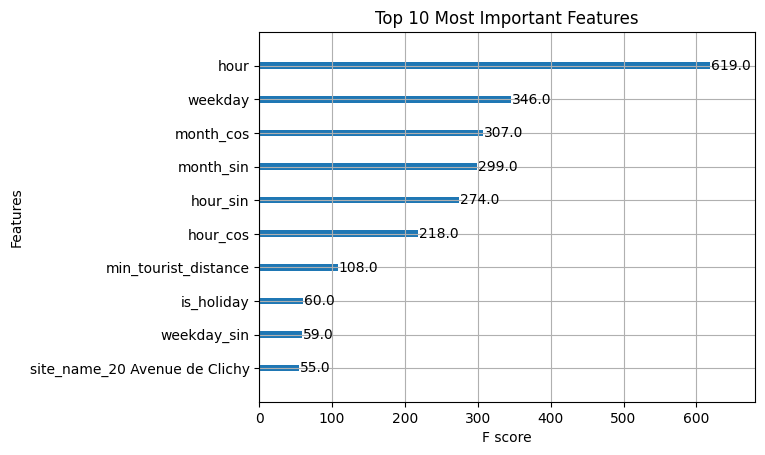

In [14]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Most Important Features")
plt.show()

In [15]:
print(xgb_model.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [ ]:
data = pd.read_parquet(Path("data") / "train.parquet")
def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Apply cyclical encoding
    X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)
    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)
    X["weekday_sin"] = np.sin(2 * np.pi * X["weekday"] / 7)
    X["weekday_cos"] = np.cos(2 * np.pi * X["weekday"] / 7)

    return X

data = _encode_dates(data)



# Define feature dropping for low predictive value and date (for the XGBoost and Histboost)
def _drop_low_value_features_grad(X):
    X = X.copy()
    X.drop(columns=['date', 'month', 'year', 'counter_id', 'date', 'counter_installation_date',
                    'counter_technical_id', 'coordinates', 'latitude', 'longitude', 'weekday'], inplace=True)
    return X
#####################################################

preprocessor_grad = Pipeline(steps=[
    ("add_rush_hour", FunctionTransformer(_add_rush_hour_indicator, validate=False)),
    ("add_weekend", FunctionTransformer(_add_weekend_indicator, validate=False)),
    ("add_holiday", FunctionTransformer(_add_holiday_indicator, validate=False)),
    ("encode_categorical", FunctionTransformer(_encode_categorical_features, validate=False)),
    ("encode_dates", FunctionTransformer(_encode_dates, validate=False)),
    ("add_tourist_proximity", FunctionTransformer(_add_tourist_proximity, validate=False)),
    ("drop_low_value_features_grad", FunctionTransformer(_drop_low_value_features_grad, validate=False)),
])

data = preprocessor_grad.fit_transform(data)

X = data.drop(columns=['bike_count', 'log_bike_count']).select_dtypes(include=['number'])
y = data['log_bike_count']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

class XGBRegressorCompat(XGBRegressor, BaseEstimator, RegressorMixin):
    def __sklearn_tags__(self):
        return {"non_deterministic": True}

features = [
    col for col in data.columns
    if col not in ["log_bike_count", "bike_count", "counter_id", "coordinates"]
]
X = data[features]
y = data["log_bike_count"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

param_distributions = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressorCompat(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random combinations to test
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_

y_train_pred = best_xgb_model.predict(X_train)
y_valid_pred = best_xgb_model.predict(X_valid)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

print(f"Best Parameters: {random_search.best_params_}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {valid_rmse:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best RMSE (CV): -0.37
Train RMSE: 0.32
Validation RMSE: 0.36


In [17]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'data' is your DataFrame containing the dataset
features = [col for col in data.columns if col not in ["log_bike_count", "bike_count", "counter_id", "coordinates"]]
X = data[features]
y = data["log_bike_count"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the HistGradientBoostingRegressor model
hgb_model = HistGradientBoostingRegressor(random_state=42)

# Fit the model
hgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = hgb_model.predict(X_train)
y_valid_pred = hgb_model.predict(X_valid)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

# Print results
print(f"HistGradientBoostingRegressor - Train RMSE: {train_rmse:.2f}")
print(f"HistGradientBoostingRegressor - Validation RMSE: {valid_rmse:.2f}")

HistGradientBoostingRegressor - Train RMSE: 0.49
HistGradientBoostingRegressor - Validation RMSE: 0.49


In [18]:
# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [20, 30, 50],
    'l2_regularization': [0.0, 0.1, 1.0]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,  # Number of random combinations to test
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Use the best model from RandomizedSearchCV
best_hgb_model = random_search.best_estimator_

# Make predictions
y_train_pred = best_hgb_model.predict(X_train)
y_valid_pred = best_hgb_model.predict(X_valid)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

# Print results
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best RMSE (CV): {abs(random_search.best_score_):.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {valid_rmse:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'min_samples_leaf': 50, 'max_iter': 300, 'max_depth': 7, 'learning_rate': 0.1, 'l2_regularization': 1.0}
Best RMSE (CV): 0.43
Train RMSE: 0.43
Validation RMSE: 0.43


# Test data

In [19]:
test_data = pd.read_parquet(Path("data") / "final_test.parquet")

In [20]:
test_data.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [21]:
test_data = _encode_dates(test_data)

# Preprocess the test data
test_data = preprocessor_grad.transform(test_data)

best_xgb_model.fit(X_train, y_train)

# Make predictions
test_predictions = best_hgb_model.predict(test_data)

## SUBMISSION.CSV CREATION

In [22]:
submission_df = pd.DataFrame({
    "Id": range(len(test_predictions)),  # Assuming sequential indices for Id
    "log_bike_count": test_predictions
})

# Save to CSV
submission_file_path = "submission.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to {submission_file_path}")

Submission file saved to submission.csv
